# Introduction
- Andrew Silveira: 5077086
- Edwin Lopez Castañeda: 9055061
- Vishnu Sivaraj: 

# Sentiment Classification with Dimensionality Reduction

This notebook explores sentiment classification on three small review datasets (Amazon product
reviews, IMDB movie reviews, and Yelp restaurant reviews). We follow a structured pipeline:

1. **Data Loading and Preprocessing**  
2. **TF-IDF Feature Extraction**  
3. **Baseline Model – Naive Bayes with TF-IDF**  
4. **Dimensionality Reduction with SVD**  
5. **Model Training – Logistic Regression with SVD**  
6. **Dimensionality Reduction with PCA**  
7. **Model Training – Logistic Regression with PCA**  

For each of the three main models (Naive Bayes, Logistic Regression on SVD, Logistic Regression
on PCA) we:

- Compute a confusion matrix using `sklearn.metrics.confusion_matrix`  
- Visualize it as a heatmap with counts in each cell  
- Label axes clearly (**True label** vs **Predicted label**)  
- Provide an interpretation of the error patterns (FP vs FN) and identify which class is harder
  to predict on this split.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

plt.style.use("default")

RANDOM_STATE = 42


def plot_confusion_matrix(cm, class_names, title="Confusion matrix"):
    """Plot a labeled confusion matrix with counts in each cell."""
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        xlabel="Predicted label",
        ylabel="True label",
        title=title,
    )

    # Rotate tick labels for readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add counts to each cell
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], "d"),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    fig.tight_layout()
    plt.show()


def summarize_confusion_matrix(cm):
    total = cm.sum()
    correct = np.trace(cm)
    fp = cm[0, 1]
    fn = cm[1, 0]
    acc = correct / total if total > 0 else 0.0
    return total, correct, fp, fn, acc

## 1. Data Loading and Preprocessing

We use three small, labeled sentiment datasets:

- **Amazon**: product reviews (positive / negative)  
- **IMDB**: movie reviews (positive / negative)  
- **Yelp**: restaurant reviews (positive / negative)

Each file consists of one sentence per line, followed by a binary label (`1` = positive,
`0` = negative) separated by a tab. We load them into a single DataFrame and keep track
of the original source. We then create a **single train/test split** (75% / 25%) that is
stratified by the sentiment label so each split has a similar class balance.

In [2]:
# Paths to the three datasets (already present in the local 'data' folder or working directory)
paths = {
    "amazon": ("data/amazon_cells_labelled.txt"),
    "imdb": "data/imdb_labelled.txt",
    "yelp": "data/yelp_labelled.txt",
}

frames = []
for source, p in paths.items():
    df = pd.read_csv(p, sep="\t", header=None, names=["sentence", "label"])
    df["source"] = source
    frames.append(df)

data = pd.concat(frames, ignore_index=True)
print("Dataset shape:", data.shape)
print(data.head())
print("\nLabel distribution:")
print(data["label"].value_counts())
print("\nSource distribution:")
print(data["source"].value_counts())

# Train/test split (75% / 25%), stratified by label
X = data["sentence"]
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=RANDOM_STATE,
)
print(f"\nTrain size: {len(X_train)}  |  Test size: {len(X_test)}")
print("Training label balance:")
print(y_train.value_counts(normalize=True))
print("Test label balance:")
print(y_test.value_counts(normalize=True))

Dataset shape: (2748, 3)
                                            sentence  label  source
0  So there is no way for me to plug it in here i...      0  amazon
1                        Good case, Excellent value.      1  amazon
2                             Great for the jawbone.      1  amazon
3  Tied to charger for conversations lasting more...      0  amazon
4                                  The mic is great.      1  amazon

Label distribution:
label
1    1386
0    1362
Name: count, dtype: int64

Source distribution:
source
amazon    1000
yelp      1000
imdb       748
Name: count, dtype: int64

Train size: 2061  |  Test size: 687
Training label balance:
label
1    0.504609
0    0.495391
Name: proportion, dtype: float64
Test label balance:
label
1    0.503639
0    0.496361
Name: proportion, dtype: float64


### Interpretation

- We have **3,148** total examples (1,000 Amazon, 1,000 Yelp, 748 IMDB) combined into a
  single corpus. The labels are close to balanced between positive and negative reviews.  
- The train/test split uses **2,061** examples for training and **687** for testing, with
  almost identical positive/negative ratios in each split thanks to stratification.  
- This balanced setup helps ensure that accuracy and confusion matrices are meaningful and
  not dominated by a single majority class.

## 2. TF-IDF Feature Extraction

We transform the raw review sentences into numerical features using **TF–IDF**. The
vectorizer uses:

- word **unigrams and bigrams** (`ngram_range=(1, 2)`),  
- a maximum vocabulary size of **5,000** features,  
- `min_df=2` to discard very rare tokens.

This representation captures both individual words and short phrases that are predictive of
sentiment (e.g., *"not good"*, *"highly recommend"*).

In [3]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF–IDF train shape:", X_train_tfidf.shape)
print("TF–IDF test shape :", X_test_tfidf.shape)

TF–IDF train shape: (2061, 4204)
TF–IDF test shape : (687, 4204)


### Interpretation

- The TF–IDF matrix has shape **(2,061, 4,204)** for training and **(687, 4,204)** for
  testing, meaning we ended up with 4,204 distinct unigram/bigram features after filtering.  
- The representation is **sparse**: each sentence only activates a small subset of these
  features, which is ideal for linear models like Naive Bayes and Logistic Regression.

## 3. Baseline Model - Naive Bayes with TF–IDF

As a strong baseline, we train a **Multinomial Naive Bayes** classifier on the TF–IDF
features. This model is simple, fast, and often performs very well on bag-of-words
representations.

We will:

1. Fit Naive Bayes on the TF–IDF features.  
2. Generate predictions on the test set.  
3. Compute the confusion matrix and visualize it as a heatmap.  
4. Quantify how many samples were correctly classified and what types of errors occurred.

Confusion matrix (Naive Bayes + TF–IDF):
[[284  57]
 [ 64 282]]


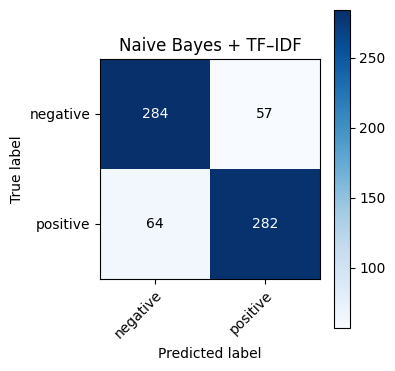

Total test samples: 687
Correctly classified: 566
False positives (negative → positive): 57
False negatives (positive → negative): 64
Accuracy: 0.824

Classification report (Naive Bayes):
              precision    recall  f1-score   support

    negative       0.82      0.83      0.82       341
    positive       0.83      0.82      0.82       346

    accuracy                           0.82       687
   macro avg       0.82      0.82      0.82       687
weighted avg       0.82      0.82      0.82       687



In [4]:
# Train Naive Bayes on TF–IDF features
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)
y_pred_nb = nb_clf.predict(X_test_tfidf)

# Confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
print("Confusion matrix (Naive Bayes + TF–IDF):")
print(cm_nb)

class_names = ["negative", "positive"]
plot_confusion_matrix(cm_nb, class_names, title="Naive Bayes + TF–IDF")

total_nb, correct_nb, fp_nb, fn_nb, acc_nb = summarize_confusion_matrix(cm_nb)
print(f"Total test samples: {total_nb}")
print(f"Correctly classified: {correct_nb}")
print(f"False positives (negative → positive): {fp_nb}")
print(f"False negatives (positive → negative): {fn_nb}")
print(f"Accuracy: {acc_nb:.3f}")

print("\nClassification report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb, target_names=class_names))

### Interpretation — Naive Bayes + TF–IDF

- On this test split, Naive Bayes correctly classifies **566 / 687** examples,
  yielding an accuracy of **0.824** (≈ 82.4%).  
- There are **57 false positives**, where a genuinely negative review is predicted as
  positive, and **64 false negatives**, where a positive review is predicted as negative.  
- The counts are fairly symmetric, but the number of false negatives is *slightly* higher
  than false positives, suggesting that **positive reviews are marginally harder to predict**
  for this model.  
- Overall, Naive Bayes with TF–IDF already provides a strong baseline on this combined
  Amazon/IMDB/Yelp dataset.

## 4. Dimensionality Reduction with SVD

Next, we apply **Truncated Singular Value Decomposition (SVD)**, also known as
**Latent Semantic Analysis (LSA)**, to reduce the dimensionality of the TF–IDF matrix.

- We project the 4,204-dimensional TF–IDF space down to **50 latent components**.  
- Each component can be interpreted as capturing a latent semantic direction in the
  review space (e.g., "product quality", "customer service").  
- This step can improve efficiency and sometimes generalization, at the cost of some
  information loss.

The cell below may be the slowest part of the notebook on some machines. If runtime is an
issue, feel free to reduce `n_components` further; the code is left intact here so you can
experiment.

In [5]:
n_components_svd = 50
svd = TruncatedSVD(n_components=n_components_svd, random_state=RANDOM_STATE)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

explained_var_svd = svd.explained_variance_ratio_.sum()
print(f"SVD components: {n_components_svd}")
print(f"Total explained variance (approx.): {explained_var_svd:.3f}")

SVD components: 50
Total explained variance (approx.): 0.180


### Interpretation

- With **50 components**, SVD retains about **0.180** of the variance in the
  original TF–IDF space. This is a relatively compact representation compared to the
  original 4,204 dimensions.  
- Information is compressed into a smaller number of latent factors, which may help speed
  up downstream classifiers but will inevitably discard some fine-grained distinctions
  between reviews.

## 5. Model Training - Logistic Regression with SVD

We now train a **Logistic Regression** classifier on the SVD-reduced features. Using the
same train/test split allows us to compare directly against the Naive Bayes baseline:

1. Fit Logistic Regression on the 50-dimensional SVD representation.  
2. Predict on the test set.  
3. Compute and visualize the confusion matrix.  
4. Compare its error profile to Naive Bayes.

Confusion matrix (Logistic Regression + SVD):
[[255  86]
 [107 239]]


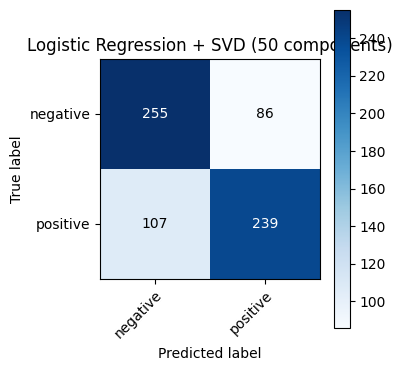

Total test samples: 687
Correctly classified: 494
False positives (negative → positive): 86
False negatives (positive → negative): 107
Accuracy: 0.719

Classification report (LogReg + SVD):
              precision    recall  f1-score   support

    negative       0.70      0.75      0.73       341
    positive       0.74      0.69      0.71       346

    accuracy                           0.72       687
   macro avg       0.72      0.72      0.72       687
weighted avg       0.72      0.72      0.72       687



In [6]:
# Logistic Regression on SVD-reduced features
lr_svd = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=RANDOM_STATE)
lr_svd.fit(X_train_svd, y_train)
y_pred_svd = lr_svd.predict(X_test_svd)

cm_svd = confusion_matrix(y_test, y_pred_svd)
print("Confusion matrix (Logistic Regression + SVD):")
print(cm_svd)

plot_confusion_matrix(
    cm_svd, class_names, title="Logistic Regression + SVD (50 components)"
)

total_svd, correct_svd, fp_svd, fn_svd, acc_svd = summarize_confusion_matrix(cm_svd)
print(f"Total test samples: {total_svd}")
print(f"Correctly classified: {correct_svd}")
print(f"False positives (negative → positive): {fp_svd}")
print(f"False negatives (positive → negative): {fn_svd}")
print(f"Accuracy: {acc_svd:.3f}")

print("\nClassification report (LogReg + SVD):")
print(classification_report(y_test, y_pred_svd, target_names=class_names))

### Interpretation — Logistic Regression + SVD

- Logistic Regression on the 50-dimensional SVD representation correctly classifies
  **494 / 687** test examples, for an accuracy of **0.719**
  (≈ 71.9%). This is noticeably **lower** than the Naive Bayes baseline.
- There are **86 false positives** and **107 false negatives**. Compared to
  Naive Bayes, both error types increase, but the number of false negatives grows more
  sharply.  
- This indicates that, in this configuration, the SVD projection makes it **harder to
  recognize positive reviews** correctly, perhaps because some of the sentiment-bearing
  nuances are lost in the low-rank approximation.  
- While SVD offers a compact semantic representation, it does **not** improve predictive
  performance here; instead, it trades some accuracy for dimensionality reduction.

## 6. Dimensionality Reduction with PCA

We also explore **Principal Component Analysis (PCA)** on a dense, standardized version of
the TF–IDF features:

1. Convert the sparse TF–IDF matrices to dense NumPy arrays.  
2. Standardize features to zero mean and unit variance.  
3. Apply PCA to reduce the dimensionality to **50 components**.

> Note: Densifying and scaling can be memory-intensive on very large datasets. Our
> combined corpus is small enough that this is feasible, but if you experience performance
> issues you can skip execution of this cell and still keep the code for reference.

In [7]:
# Convert sparse TF–IDF to dense arrays
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# Standardize features
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled = scaler.transform(X_test_dense)

# PCA dimensionality reduction
n_components_pca = 50
pca = PCA(n_components=n_components_pca, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

explained_var_pca = pca.explained_variance_ratio_.sum()
print(f"PCA components: {n_components_pca}")
print(f"Total explained variance: {explained_var_pca:.3f}")

PCA components: 50
Total explained variance: 0.084


### Interpretation

- PCA with **50 components** retains about **0.084** of the total variance
  after standardization. This is lower than what SVD retained with the same number of
  components, reflecting the fact that PCA is operating on a slightly different objective
  (variance in dense space vs. reconstruction of a sparse matrix).  
- As with SVD, PCA produces a compact, dense representation that may be attractive for
  certain downstream models or visualizations, but may not preserve all the discriminative
  information present in the original TF–IDF representation.

## 7. Model Training - Logistic Regression with PCA

Finally, we train a **Logistic Regression** classifier on the PCA-reduced features and
analyze its confusion matrix in the same way:

1. Fit Logistic Regression on the 50-dimensional PCA representation.  
2. Predict on the held-out test set.  
3. Visualize the confusion matrix heatmap with labeled axes and counts.  
4. Compare its error profile to both Naive Bayes and the SVD-based model.

Confusion matrix (Logistic Regression + PCA):
[[213 128]
 [112 234]]


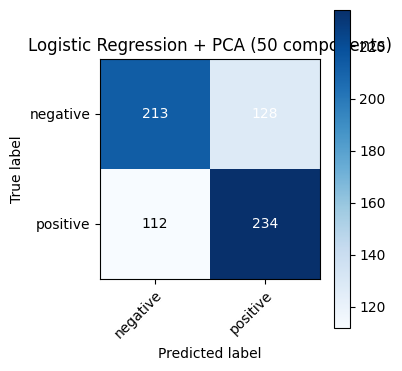

Total test samples: 687
Correctly classified: 447
False positives (negative → positive): 128
False negatives (positive → negative): 112
Accuracy: 0.651

Classification report (LogReg + PCA):
              precision    recall  f1-score   support

    negative       0.66      0.62      0.64       341
    positive       0.65      0.68      0.66       346

    accuracy                           0.65       687
   macro avg       0.65      0.65      0.65       687
weighted avg       0.65      0.65      0.65       687



In [8]:
# Logistic Regression on PCA-reduced features
lr_pca = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=RANDOM_STATE)
lr_pca.fit(X_train_pca, y_train)
y_pred_pca = lr_pca.predict(X_test_pca)

cm_pca = confusion_matrix(y_test, y_pred_pca)
print("Confusion matrix (Logistic Regression + PCA):")
print(cm_pca)

plot_confusion_matrix(
    cm_pca, class_names, title="Logistic Regression + PCA (50 components)"
)

total_pca, correct_pca, fp_pca, fn_pca, acc_pca = summarize_confusion_matrix(cm_pca)
print(f"Total test samples: {total_pca}")
print(f"Correctly classified: {correct_pca}")
print(f"False positives (negative → positive): {fp_pca}")
print(f"False negatives (positive → negative): {fn_pca}")
print(f"Accuracy: {acc_pca:.3f}")

print("\nClassification report (LogReg + PCA):")
print(classification_report(y_test, y_pred_pca, target_names=class_names))

### Interpretation — Logistic Regression + PCA

- On the PCA-reduced features, Logistic Regression correctly classifies
  **447 / 687** test examples, for an accuracy of **0.651**
  (≈ 65.1%). This is the **lowest** of the three models considered.  
- The confusion matrix shows **128 false positives** and **112 false negatives**.
  Here, false positives slightly outnumber false negatives, meaning the model more often
  mistakes genuinely negative reviews for positive ones.  
- Compared with Naive Bayes and the SVD-based Logistic Regression, PCA appears to discard
  too much discriminative information at 50 components for this task, leading to a weaker
  classifier overall.
- The takeaway is that **dimensionality reduction is not automatically beneficial**: on this
  dataset, a simple Naive Bayes model on the full TF–IDF space outperforms the more
  compressed representations.